In [1]:
!pip install XGBoost

In [2]:
import xgboost as xgb
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [3]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()

In [4]:
breast_cancer

{'DESCR': '.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry \n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        largest values) of these features were computed for each image,\n        resulting in 30 features.  For

In [5]:
X, y = breast_cancer['data'], breast_cancer['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_nn = ss.fit_transform(X_train)
X_test_nn = ss.transform(X_test)


dtclassifier = DecisionTreeClassifier(max_depth=4)
dtclassifier.fit(X_train_nn, y_train)
pred = dtclassifier.predict(X_test_nn)
dtclassifier.score(X_test_nn, y_test)

0.9736842105263158

In [7]:
xgbclassifier = xgb.XGBClassifier(n_estimators=10, max_depth = 3, objective='reg:logistic', random_state=123)
xgbclassifier.fit(X_train_nn, y_train)
xgbclassifier.predict(X_test_nn)
xgbclassifier.score(X_test_nn, y_test)

0.9736842105263158

In [8]:
breast_dmatrix = xgb.DMatrix(data=X_train_nn, label = y_train)
params = {'objective':'reg:logistic', 'max_depth':3}

cv_results = xgb.cv(dtrain=breast_dmatrix, params = params, nfold=3, num_boost_round=5, metrics = "error", as_pandas=True, seed=123)
print(cv_results)
print(1-cv_results["test-error-mean"].tail(1))

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.027474         0.006786         0.068200        0.027285
1          0.021977         0.006778         0.070364        0.017436
2          0.012087         0.001546         0.065978        0.016347
3          0.010994         0.004124         0.061593        0.017531
4          0.008797         0.004121         0.065978        0.016347
4    0.934022
Name: test-error-mean, dtype: float64


In [9]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()

X1, y1 = boston_dataset['data'], boston_dataset['target']

X1_train, X1_test, y1train, y1test = train_test_split(X1, y1, test_size=0.2, random_state=123)
new_scaler = StandardScaler().fit(X1_train)
scaled_x1train = new_scaler.transform(X1_train)
scaled_x1test = new_scaler.transform(X1_test)

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(seed=123, objective="reg:squarederror", n_estimators=10)
xg_reg.fit(scaled_x1train, y1train)
preds = xg_reg.predict(scaled_x1test)

rmse = np.sqrt(mean_squared_error(preds, y1test))
rmse

9.749040710172004

In [12]:
train_dmatrix = xgb.DMatrix(scaled_x1train, y1train)
test_dmatrix = xgb.DMatrix(scaled_x1test, y1test)

params = {"booster":"gblinear", "objective":"reg:linear"}

xg_reg = xgb.train(params=params, dtrain=train_dmatrix, num_boost_round=5)
preds = xg_reg.predict(test_dmatrix)

rmse = np.sqrt(mean_squared_error(y1test,preds))
rmse

[02:52:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


5.52931654520667

In [14]:
params = {"objective":"reg:squarederror", "max_depth":4}
cv_results = xgb.cv(dtrain=train_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
print((cv_results["test-rmse-mean"]).tail(1))

4    5.894654
Name: test-rmse-mean, dtype: float64


In [17]:
import pandas as pd
reg_params = [1, 10, 100]
params = {"objective":"reg:squarederror","max_depth":3}
rmses_l2 = []
for reg in reg_params:
    params["lambda"] = reg
    cv_results_rmse = xgb.cv(dtrain=train_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)),columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2       rmse
0    1   6.093934
1   10   7.503163
2  100  11.240374


[02:58:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


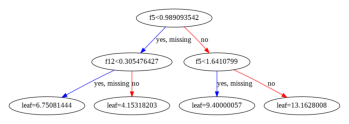

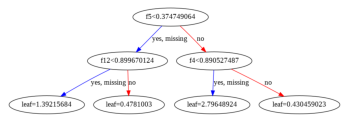

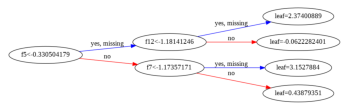

In [19]:
import matplotlib.pyplot as plt
params = {"objective":"reg:linear", "max_depth":2}
xg_reg = xgb.train(params=params, dtrain=train_dmatrix, num_boost_round=10)
xgb.plot_tree(xg_reg, num_trees=0)
plt.show()


xgb.plot_tree(xg_reg, num_trees=4)
plt.show()

xgb.plot_tree(xg_reg, num_trees=9, rankdir="LR")
plt.show()

[02:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


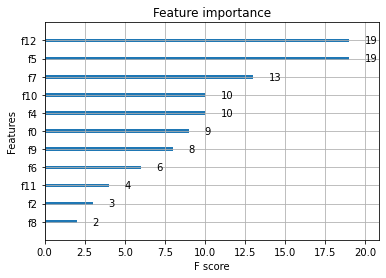

In [20]:
params = {"objective":'reg:linear', 'max_depth':4}
xg_reg = xgb.train(dtrain=train_dmatrix, num_boost_round=10, params=params)
xgb.plot_importance(xg_reg)
plt.show()

In [21]:
print(boston_dataset['feature_names'])

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
